In [1]:
from importlib import reload
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import gdecomp
import pandas as pd

## Gaussian Decomposition

<Figure size 800x600 with 0 Axes>

Text(0.5, 1.0, 'Sum of Two Gaussians')

Text(0.5, 0, 'X-axis')

Text(0, 0.5, 'Y-axis')

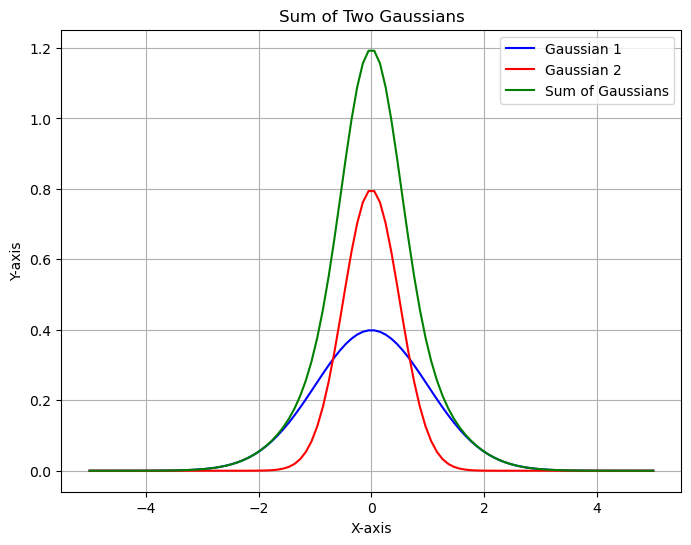

In [4]:
%matplotlib inline
# Define the Gaussian function
def gaussian(x, mean, std_dev, amp = 1):
    return amp * np.exp(-(x - mean)**2 / (2 * std_dev**2)) / (std_dev * np.sqrt(2 * np.pi))

# Set up x-values and Gaussian parameters
x = np.linspace(-5, 5, 100)
mean1, std_dev1 = 0, 1
mean2, std_dev2 = 0, 0.5

# Calculate the Gaussian functions
gaussian1 = gaussian(x, mean1, std_dev1)
gaussian2 = gaussian(x, mean2, std_dev2)

# Calculate the sum of Gaussians
sum_of_gaussians = gaussian1 + gaussian2

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(x, gaussian1, label='Gaussian 1', color='blue')
plt.plot(x, gaussian2, label='Gaussian 2', color='red')
plt.plot(x, sum_of_gaussians, label='Sum of Gaussians', color='green')
plt.legend()
plt.title('Sum of Two Gaussians')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.grid(True)

[[18.87853616 49.5         6.53849514]]
0


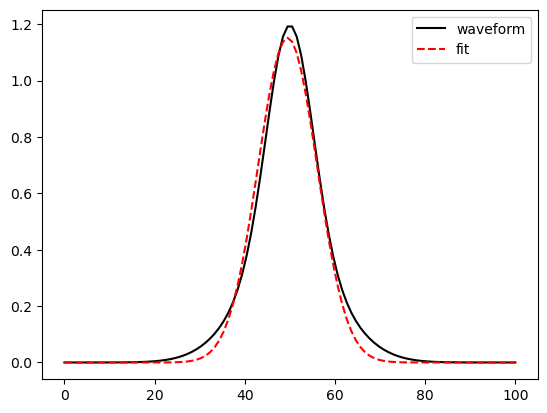

In [6]:
x = np.linspace(0, 100, 100)
out = gdecomp.GaussianDecomposition(sum_of_gaussians)
out = np.reshape(out, (-1, 3))
print(out)
fit = np.zeros(sum_of_gaussians.size)
for i in range(out.shape[0]):
    print(i)
    fit += gaussian(x, out[i, 1], out[i, 2], out[i, 0])

line1 = plt.plot(x, sum_of_gaussians, color='k', label='waveform')
line2 = plt.plot(x, fit, color='r', linestyle='--', label='fit')
plt.legend(loc='upper right')

# Maxquant MSMS

## Preprocessing and matching with evidence.txt

In [14]:
maxquant_file =  '/mnt/cmnfs/proj/ORIGINS/data/protMSD/GCF_profile/combined/txt/evidence.txt' # path to MaxQuant results (evidence.txt) of the same RAW file, used for constructing reference dictionary
maxquant_msms_RTpred_file = 'msms_with_predRT.txt'
msconvert_file = '/mnt/cmnfs/proj/ORIGINS/data/protMSD/GCF_profile/msconvert_profile.mzML' # path to the data input in mzML format, containing only MS1 level data
MS1Scans_NoArray_file = '/mnt/cmnfs/proj/ORIGINS/data/protMSD/GCF_profile/MS1Scans_NoArray.csv'
Maxquant_result = pd.read_csv(filepath_or_buffer=maxquant_file, sep='\t')
Maxquant_msms = pd.read_csv(filepath_or_buffer=maxquant_msms_RTpred_file, sep='\t')
MS1Scans_NoArray = pd.read_csv(MS1Scans_NoArray_file)

In [8]:
msms_modseq_charge = Maxquant_msms.groupby(by = ['Modified sequence', 'Charge']).first().reset_index()
evidence_modseq_charge = Maxquant_result.groupby(by = ['Modified sequence', 'Charge'])['Intensity'].sum().reset_index()

In [9]:
import pickle
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from optimization.dictionary import LoadMZML
# Load MS1 scans from pkl or mzml file
try:
    with open(msconvert_file[:-5]+'.pkl', 'rb') as f:
        MS1Scans = pickle.load(f)
    print('Load pre-stored pickle results')
except:
    print('Pickle result not found, load mzml file.')
    MS1Scans = LoadMZML(msconvert_file)
    MS1Scans.to_pickle(msconvert_file[:-5]+'.pkl')

Load pre-stored pickle results


<module 'utils.metrics' from '/mnt/cmnfs/proj/ORIGINS/protMSD/maxquant/ScanByScan/utils/metrics.py'>

10.128148591555036

Green line shows deltaRT 95
Data:  Retention time predicted_RT , slope =  0.969 , intercept =  0.987 , PearsonR =  0.987 , SpearmanR =  0.989


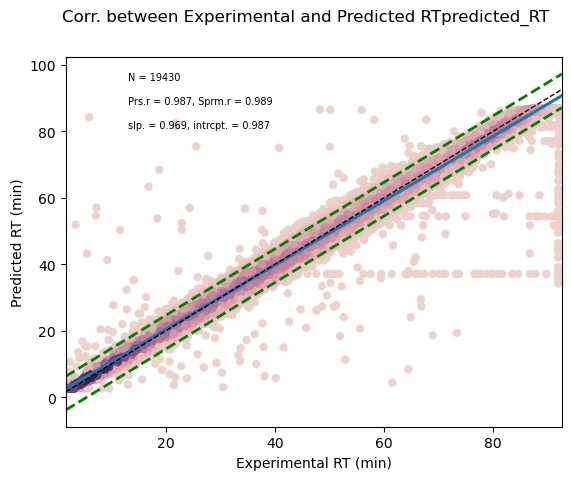

In [15]:
MS1Scans_NoArray['ScanIndex'] = MS1Scans_NoArray.index
# Append predicted RT to maxquant result
Maxquant_result = pd.merge(left=Maxquant_result, 
                           right=msms_modseq_charge[['Modified sequence', 'Charge', 'predicted_RT']],
                           on=['Modified sequence', 'Charge'],
                           how='left')
Maxquant_result['RT_delta'] = Maxquant_result['Retention time'] - Maxquant_result['predicted_RT']
Maxquant_result.to_csv('/mnt/cmnfs/proj/ORIGINS/data/protMSD/GCF_profile/combined/txt/evidence_withPredRT.txt',
                       sep='\t')
# evaluate RT prediction
import utils.metrics
reload(utils.metrics)
from utils.metrics import RT_metrics

RT_eval = RT_metrics(RT_obs=Maxquant_result['Retention time'],
                     RT_pred=Maxquant_result['predicted_RT'])
RT_eval.CalcDeltaRTwidth()
RT_eval.PlotRTScatter()

In [23]:
Maxquant_result.columns

Index(['Sequence', 'Length', 'Modifications', 'Modified sequence',
       'Oxidation (M) Probabilities', 'Oxidation (M) Score Diffs',
       'Acetyl (Protein N-term)', 'Oxidation (M)', 'Missed cleavages',
       'Proteins', 'Leading proteins', 'Leading razor protein', 'Type',
       'Raw file', 'Experiment', 'MS/MS m/z', 'Charge', 'm/z', 'Mass',
       'Resolution', 'Uncalibrated - Calibrated m/z [ppm]',
       'Uncalibrated - Calibrated m/z [Da]', 'Mass error [ppm]',
       'Mass error [Da]', 'Uncalibrated mass error [ppm]',
       'Uncalibrated mass error [Da]', 'Max intensity m/z 0', 'Retention time',
       'Retention length', 'Calibrated retention time',
       'Calibrated retention time start', 'Calibrated retention time finish',
       'Retention time calibration', 'Match time difference',
       'Match m/z difference', 'Match q-value', 'Match score',
       'Number of data points', 'Number of scans', 'Number of isotopic peaks',
       'PIF', 'Fraction of total spectrum', 'Base 

In [22]:
view = Maxquant_result[['Modified sequence', 'Proteins','Charge', 'Reverse','predicted_RT', 'Intensity','Calibrated retention time start','Calibrated retention time finish','Retention time', 'RT_delta']]

In [21]:
test = view.groupby(by = ['Modified sequence', 'Charge']).count()

In [ ]:
msms_modseq_charge_scan = pd.merge_asof(left = msms_modseq_charge.sort_values(by = 'predicted_RT'), 
                                        right=MS1Scans_NoArray[['ScanIndex','starttime']],
                                        #right_index=True,
                                        direction='nearest',
                                        left_on='predicted_RT',
                                        right_on='starttime',
                                        suffixes=['', '_scan'])
cols_to_preserved = ['Modified sequence', 'Charge', 'predicted_RT', 'ScanIndex', 'Retention time', 
                     'Calibrated retention time start', 'Calibrated retention time finish']
evidence_modseq_charge_predRT_scan = pd.merge(left=evidence_modseq_charge,
                                              right=msms_modseq_charge_scan[['Modified sequence', 'Charge', 
                                                                             'predicted_RT', 'ScanIndex', 'Retention time']],
                                              on=['Modified sequence', 'Charge'])


In [16]:
from optimization.dictionary import CalcModpeptIsopattern
msms_modseq_charge_scan['IsoMZ'], msms_modseq_charge_scan['IsoAbundance'] = \
    zip(*msms_modseq_charge_scan.apply(lambda row: CalcModpeptIsopattern(modpept=row['Modified sequence'], 
                                                                         charge=row['Charge'], 
                                                                         ab_thres = 0.01), 
                                                                         axis=1))
msms_modseq_charge_scan = pd.merge_asof(left = msms_modseq_charge_scan.sort_values('Retention time'), 
                       right=MS1Scans_NoArray[['ScanIndex', 'starttime']], 
                       left_on='Retention time', 
                       right_on='starttime',
                       direction='nearest',
                       suffixes=['', '_true'])
msms_modseq_charge_scan.sort_values(by = 'id', inplace=True)


In [34]:
import optimization.dictionary
reload(optimization.dictionary)
from optimization.dictionary import locate_RT_range
import logging
reload(logging)
logging.basicConfig(format='%(asctime)s - %(name)s - %(levelname)s - %(message)s', level=logging.DEBUG)
precursor_idx = 20
locate_RT_range(precursorRow=msms_modseq_charge_scan.iloc[precursor_idx, :],
             MS1Scans = MS1Scans,
             search_range = 100,
             ScanIdx=msms_modseq_charge_scan['ScanIndex'].iloc[precursor_idx])

<module 'optimization.dictionary' from '/mnt/cmnfs/proj/ORIGINS/protMSD/maxquant/ScanByScan/optimization/dictionary.py'>

<module 'logging' from '/home/zixuanxiao/miniconda3/lib/python3.10/logging/__init__.py'>

2023-10-25 13:41:21,195 - root - DEBUG - Start scan = 2281, Scan edge = (2181, 2381)
2023-10-25 13:41:21,205 - root - DEBUG - Precursor 24 is not observed in seeding Scan 2281, start searching scan 2280 and 2282.
2023-10-25 13:41:21,218 - root - DEBUG - Precursor 24 not observed in scan 2280 and 2282, search with increased step


2023-10-25 13:41:21,234 - root - DEBUG - Precursor 24 not observed in scan 2279 and 2283, search with increased step
2023-10-25 13:41:21,246 - root - DEBUG - Precursor 24 not observed in scan 2278 and 2284, search with increased step
2023-10-25 13:41:21,264 - root - DEBUG - Precursor 24 not observed in scan 2277 and 2285, search with increased step
2023-10-25 13:41:21,280 - root - DEBUG - Precursor 24 not observed in scan 2276 and 2286, search with increased step
2023-10-25 13:41:21,290 - root - DEBUG - Precursor 24 not observed in scan 2275 and 2287, search with increased step
2023-10-25 13:41:21,306 - root - DEBUG - Precursor 24 not observed in scan 2274 and 2288, search with increased step
2023-10-25 13:41:21,319 - root - DEBUG - Precursor 24 not observed in scan 2273 and 2289, search with increased step
2023-10-25 13:41:21,329 - root - DEBUG - Precursor 24 not observed in scan 2272 and 2290, search with increased step
2023-10-25 13:41:21,338 - root - DEBUG - Precursor 24 not observ

(2317, 2319)

In [35]:
import logging
reload(logging)
logging.basicConfig(format='%(asctime)s - %(name)s - %(levelname)s - %(message)s', level=logging.INFO)
sample = msms_modseq_charge_scan.sample(400)
sample['inferred_start_scan'] = 0
sample['inferred_end_scan'] = 0
for precursor_idx in sample.index:
    precursor_idx
    sample.loc[precursor_idx, ['inferred_start_scan', 'inferred_end_scan']] = \
        locate_RT_range(precursorRow=sample.loc[precursor_idx, :],
                        MS1Scans = MS1Scans,
                        search_range = 100,
                        ScanIdx=sample.loc[precursor_idx, 'ScanIndex'])

<module 'logging' from '/home/zixuanxiao/miniconda3/lib/python3.10/logging/__init__.py'>

2922

2023-10-25 13:41:32,373 - root - INFO - Found scan index with direction 1: 1155


13398

2023-10-25 13:41:33,256 - root - INFO - Scan index out of predefined range, stop searching


10540

2023-10-25 13:41:34,134 - root - INFO - Found scan index with direction -1: 2177


13825

2023-10-25 13:41:34,270 - root - INFO - Found scan index with direction -1: 2868


2906

2023-10-25 13:41:34,306 - root - INFO - Found scan index with direction 1: 1146


4069

2023-10-25 13:41:35,357 - root - INFO - Found scan index with direction -1: 1333


6939

2023-10-25 13:41:35,391 - root - INFO - Found scan index with direction 1: 1960


548

2023-10-25 13:41:35,461 - root - INFO - Found scan index with direction 1: 761


7497

2023-10-25 13:41:35,756 - root - INFO - Found scan index with direction -1: 1968


6206

2023-10-25 13:41:36,789 - root - INFO - Scan index out of predefined range, stop searching


17612

2023-10-25 13:41:37,051 - root - INFO - Found scan index with direction -1: 4073


4529

2023-10-25 13:41:37,803 - root - INFO - Found scan index with direction 1: 1348


9599

2023-10-25 13:41:37,987 - root - INFO - Found scan index with direction -1: 2154


2816

2023-10-25 13:41:38,154 - root - INFO - Found scan index with direction -1: 1079


8292

2023-10-25 13:41:38,360 - root - INFO - Found scan index with direction -1: 2106


9586

2023-10-25 13:41:39,457 - root - INFO - Scan index out of predefined range, stop searching


12148

2023-10-25 13:41:39,518 - root - INFO - Found scan index with direction -1: 2739
2023-10-25 13:41:39,528 - root - INFO - Found scan index with direction 1: 2748


16558

2023-10-25 13:41:40,567 - root - INFO - Scan index out of predefined range, stop searching


5670

2023-10-25 13:41:40,631 - root - INFO - Found scan index with direction -1: 1563


10877

2023-10-25 13:41:41,058 - root - INFO - Found scan index with direction 1: 2686


6126

2023-10-25 13:41:41,221 - root - INFO - Found scan index with direction -1: 1684
2023-10-25 13:41:41,274 - root - INFO - Found scan index with direction 1: 1706


10536

2023-10-25 13:41:41,434 - root - INFO - Found scan index with direction -1: 2524


4174

2023-10-25 13:41:42,245 - root - INFO - Found scan index with direction 1: 1537


6418

2023-10-25 13:41:42,341 - root - INFO - Found scan index with direction -1: 1870


1908

2023-10-25 13:41:42,532 - root - INFO - Found scan index with direction -1: 1025


1950

2023-10-25 13:41:43,046 - root - INFO - Found scan index with direction -1: 921


12449

2023-10-25 13:41:43,572 - root - INFO - Found scan index with direction -1: 2963


11930

2023-10-25 13:41:43,934 - root - INFO - Found scan index with direction 1: 2712


15458

2023-10-25 13:41:44,365 - root - INFO - Found scan index with direction -1: 3541


12959

2023-10-25 13:41:44,477 - root - INFO - Found scan index with direction -1: 2893
2023-10-25 13:41:44,512 - root - INFO - Found scan index with direction 1: 2913


12603

2023-10-25 13:41:45,624 - root - INFO - Scan index out of predefined range, stop searching


12423

2023-10-25 13:41:45,809 - root - INFO - Found scan index with direction -1: 2852


758

2023-10-25 13:41:45,834 - root - INFO - Found scan index with direction -1: 771
2023-10-25 13:41:45,876 - root - INFO - Found scan index with direction 1: 781


7521

2023-10-25 13:41:46,361 - root - INFO - Found scan index with direction -1: 1961


7561

2023-10-25 13:41:46,580 - root - INFO - Found scan index with direction 1: 1900


18161

2023-10-25 13:41:46,597 - root - INFO - Found scan index with direction -1: 4210
2023-10-25 13:41:46,632 - root - INFO - Found scan index with direction 1: 4217


7174

2023-10-25 13:41:46,776 - root - INFO - Found scan index with direction -1: 1860
2023-10-25 13:41:46,944 - root - INFO - Found scan index with direction 1: 1898


8

2023-10-25 13:41:47,041 - root - INFO - Found scan index with direction -1: 707


14351

2023-10-25 13:41:48,133 - root - INFO - Scan index out of predefined range, stop searching


8621

2023-10-25 13:41:49,088 - root - INFO - Found scan index with direction -1: 1841


3584

2023-10-25 13:41:49,594 - root - INFO - Found scan index with direction 1: 1218


11523

2023-10-25 13:41:49,752 - root - INFO - Found scan index with direction -1: 2564


3797

2023-10-25 13:41:49,824 - root - INFO - Found scan index with direction -1: 1241


11706

2023-10-25 13:41:50,741 - root - INFO - Found scan index with direction -1: 2650


10846

2023-10-25 13:41:50,929 - root - INFO - Found scan index with direction -1: 2748


17491

2023-10-25 13:41:51,123 - root - INFO - Found scan index with direction -1: 4036


10951

2023-10-25 13:41:53,052 - root - INFO - Found scan index with direction 1: 2793


4149

2023-10-25 13:41:53,212 - root - INFO - Found scan index with direction 1: 1330


16843

2023-10-25 13:41:53,472 - root - INFO - Found scan index with direction -1: 3949


8038

2023-10-25 13:41:53,578 - root - INFO - Found scan index with direction -1: 2000
2023-10-25 13:41:53,655 - root - INFO - Found scan index with direction 1: 2023


3218

2023-10-25 13:41:53,807 - root - INFO - Found scan index with direction 1: 1203


17079

2023-10-25 13:41:54,519 - root - INFO - Found scan index with direction -1: 3980


3551

2023-10-25 13:41:54,836 - root - INFO - Found scan index with direction 1: 1227


3069

2023-10-25 13:41:54,996 - root - INFO - Found scan index with direction -1: 1122


17679

2023-10-25 13:41:55,146 - root - INFO - Found scan index with direction 1: 4111


10379

2023-10-25 13:41:55,437 - root - INFO - Found scan index with direction 1: 2512


3061

2023-10-25 13:41:55,589 - root - INFO - Found scan index with direction -1: 1224


10289

2023-10-25 13:41:55,694 - root - INFO - Found scan index with direction -1: 2379


4062

2023-10-25 13:41:55,894 - root - INFO - Found scan index with direction 1: 1390


12771

2023-10-25 13:41:56,043 - root - INFO - Found scan index with direction -1: 2872


12766

2023-10-25 13:41:56,518 - root - INFO - Found scan index with direction 1: 2889


14626

2023-10-25 13:41:57,542 - root - INFO - Found scan index with direction 1: 3293


16594

2023-10-25 13:41:57,614 - root - INFO - Found scan index with direction -1: 3877


886

2023-10-25 13:41:57,756 - root - INFO - Found scan index with direction -1: 792


11981

2023-10-25 13:41:58,267 - root - INFO - Found scan index with direction 1: 2709


944

2023-10-25 13:41:58,310 - root - INFO - Found scan index with direction -1: 789


434

2023-10-25 13:41:58,361 - root - INFO - Found scan index with direction -1: 740


10015

2023-10-25 13:41:58,820 - root - INFO - Found scan index with direction -1: 2420


667

2023-10-25 13:41:58,972 - root - INFO - Found scan index with direction -1: 770


4622

2023-10-25 13:41:59,502 - root - INFO - Found scan index with direction -1: 1408


6955

2023-10-25 13:42:00,707 - root - INFO - Found scan index with direction -1: 1828


13322

2023-10-25 13:42:00,764 - root - INFO - Found scan index with direction -1: 3057
2023-10-25 13:42:00,813 - root - INFO - Found scan index with direction 1: 3068


8903

2023-10-25 13:42:00,975 - root - INFO - Found scan index with direction -1: 2181


11398

2023-10-25 13:42:01,987 - root - INFO - Scan index out of predefined range, stop searching


274

2023-10-25 13:42:02,004 - root - INFO - Found scan index with direction -1: 708
2023-10-25 13:42:02,012 - root - INFO - Found scan index with direction 1: 712


16430

2023-10-25 13:42:02,617 - root - INFO - Found scan index with direction -1: 3883


16106

2023-10-25 13:42:02,820 - root - INFO - Found scan index with direction -1: 3885


16196

2023-10-25 13:42:03,711 - root - INFO - Scan index out of predefined range, stop searching


12192

2023-10-25 13:42:04,206 - root - INFO - Found scan index with direction -1: 2610


9534

2023-10-25 13:42:04,272 - root - INFO - Found scan index with direction 1: 2221


7885

2023-10-25 13:42:04,390 - root - INFO - Found scan index with direction 1: 1882


12467

2023-10-25 13:42:04,654 - root - INFO - Found scan index with direction 1: 2809


14016

2023-10-25 13:42:04,800 - root - INFO - Found scan index with direction -1: 3182


11617

2023-10-25 13:42:04,868 - root - INFO - Found scan index with direction 1: 2632


3984

2023-10-25 13:42:04,889 - root - INFO - Found scan index with direction -1: 1343
2023-10-25 13:42:04,903 - root - INFO - Found scan index with direction 1: 1349


3902

2023-10-25 13:42:05,213 - root - INFO - Found scan index with direction 1: 1424


6409

2023-10-25 13:42:05,323 - root - INFO - Found scan index with direction 1: 1831


9861

2023-10-25 13:42:05,670 - root - INFO - Found scan index with direction -1: 2321


11737

2023-10-25 13:42:05,737 - root - INFO - Found scan index with direction -1: 2654


7526

2023-10-25 13:42:06,151 - root - INFO - Found scan index with direction 1: 1932


14869

2023-10-25 13:42:06,845 - root - INFO - Found scan index with direction 1: 3387


9165

2023-10-25 13:42:07,341 - root - INFO - Found scan index with direction 1: 2211


8172

2023-10-25 13:42:07,542 - root - INFO - Found scan index with direction -1: 2022


9164

2023-10-25 13:42:07,794 - root - INFO - Found scan index with direction 1: 2120


5148

2023-10-25 13:42:07,833 - root - INFO - Found scan index with direction -1: 1492
2023-10-25 13:42:07,906 - root - INFO - Found scan index with direction 1: 1512


12946

2023-10-25 13:42:07,951 - root - INFO - Found scan index with direction -1: 2958


50

2023-10-25 13:42:08,000 - root - INFO - Found scan index with direction -1: 705


9672

2023-10-25 13:42:08,187 - root - INFO - Found scan index with direction -1: 2103


18373

2023-10-25 13:42:09,025 - root - INFO - Found scan index with direction -1: 4107


18265

2023-10-25 13:42:09,267 - root - INFO - Found scan index with direction 1: 4255


1583

2023-10-25 13:42:09,364 - root - INFO - Found scan index with direction -1: 872
2023-10-25 13:42:09,370 - root - INFO - Found scan index with direction 1: 892


16266

2023-10-25 13:42:09,397 - root - INFO - Found scan index with direction -1: 3702


2373

2023-10-25 13:42:09,450 - root - INFO - Found scan index with direction 1: 987


6713

2023-10-25 13:42:09,664 - root - INFO - Found scan index with direction 1: 1735


12979

2023-10-25 13:42:09,994 - root - INFO - Found scan index with direction -1: 2915


692

2023-10-25 13:42:10,035 - root - INFO - Found scan index with direction -1: 771


14515

2023-10-25 13:42:10,125 - root - INFO - Found scan index with direction -1: 3286


5491

2023-10-25 13:42:10,502 - root - INFO - Found scan index with direction -1: 1643


11310

2023-10-25 13:42:10,529 - root - INFO - Found scan index with direction 1: 2839


1321

2023-10-25 13:42:11,357 - root - INFO - Scan index out of predefined range, stop searching


12850

2023-10-25 13:42:11,435 - root - INFO - Found scan index with direction -1: 2828


18118

2023-10-25 13:42:11,459 - root - INFO - Found scan index with direction -1: 4198
2023-10-25 13:42:11,488 - root - INFO - Found scan index with direction 1: 4207


681

2023-10-25 13:42:11,510 - root - INFO - Found scan index with direction -1: 769
2023-10-25 13:42:11,521 - root - INFO - Found scan index with direction 1: 774


459

2023-10-25 13:42:11,589 - root - INFO - Found scan index with direction 1: 742


6684

2023-10-25 13:42:11,816 - root - INFO - Found scan index with direction 1: 1906


11364

2023-10-25 13:42:12,022 - root - INFO - Found scan index with direction -1: 2598


1010

2023-10-25 13:42:12,276 - root - INFO - Found scan index with direction 1: 811


3739

2023-10-25 13:42:12,421 - root - INFO - Found scan index with direction -1: 1241


13936

2023-10-25 13:42:12,471 - root - INFO - Found scan index with direction -1: 3256


9425

2023-10-25 13:42:12,663 - root - WARNING - Precursor 18603 observed in equal distance scan 2154 and 2202,                                 incorporate empty scans in the middle
2023-10-25 13:42:12,669 - root - INFO - Found scan index with direction -1: 2153
2023-10-25 13:42:12,679 - root - INFO - Found scan index with direction 1: 2204


5077

2023-10-25 13:42:13,039 - root - INFO - Found scan index with direction 1: 1577


15872

2023-10-25 13:42:13,562 - root - INFO - Found scan index with direction 1: 3617


15153

2023-10-25 13:42:13,741 - root - INFO - Found scan index with direction 1: 3450


8655

2023-10-25 13:42:14,303 - root - INFO - Found scan index with direction -1: 1950


11594

2023-10-25 13:42:15,131 - root - INFO - Scan index out of predefined range, stop searching


9803

2023-10-25 13:42:15,877 - root - INFO - Scan index out of predefined range, stop searching


15112

2023-10-25 13:42:16,371 - root - INFO - Found scan index with direction 1: 3341


16797

2023-10-25 13:42:16,463 - root - INFO - Found scan index with direction 1: 3921


10463

2023-10-25 13:42:17,067 - root - INFO - Found scan index with direction -1: 2436


1837

2023-10-25 13:42:17,122 - root - INFO - Found scan index with direction 1: 990


7139

2023-10-25 13:42:17,252 - root - INFO - Found scan index with direction -1: 1856


5547

2023-10-25 13:42:18,025 - root - INFO - Scan index out of predefined range, stop searching


12988

2023-10-25 13:42:18,772 - root - INFO - Scan index out of predefined range, stop searching


2134

2023-10-25 13:42:18,853 - root - INFO - Found scan index with direction 1: 983


14922

2023-10-25 13:42:19,630 - root - INFO - Scan index out of predefined range, stop searching


1381

2023-10-25 13:42:19,646 - root - INFO - Found scan index with direction -1: 849
2023-10-25 13:42:19,666 - root - INFO - Found scan index with direction 1: 855


15793

2023-10-25 13:42:20,384 - root - INFO - Scan index out of predefined range, stop searching


4587

2023-10-25 13:42:20,426 - root - INFO - Found scan index with direction -1: 1332


5816

2023-10-25 13:42:20,769 - root - INFO - Found scan index with direction -1: 1626
2023-10-25 13:42:20,793 - root - INFO - Found scan index with direction 1: 1700


12150

2023-10-25 13:42:20,937 - root - INFO - Found scan index with direction -1: 2739


8567

2023-10-25 13:42:21,596 - root - INFO - Found scan index with direction -1: 2195


15371

2023-10-25 13:42:22,358 - root - INFO - Scan index out of predefined range, stop searching


12746

2023-10-25 13:42:23,156 - root - INFO - Scan index out of predefined range, stop searching


3870

2023-10-25 13:42:23,267 - root - INFO - Found scan index with direction -1: 1302


12155

2023-10-25 13:42:23,287 - root - INFO - Found scan index with direction 1: 2768


3167

2023-10-25 13:42:23,300 - root - INFO - Found scan index with direction -1: 1158
2023-10-25 13:42:23,307 - root - INFO - Found scan index with direction 1: 1162


11618

2023-10-25 13:42:23,320 - root - INFO - Found scan index with direction -1: 2654
2023-10-25 13:42:23,328 - root - INFO - Found scan index with direction 1: 2658


10732

2023-10-25 13:42:23,458 - root - INFO - Found scan index with direction 1: 2490


8653

2023-10-25 13:42:23,781 - root - INFO - Found scan index with direction -1: 2097


7890

2023-10-25 13:42:23,946 - root - INFO - Found scan index with direction -1: 2024


14947

2023-10-25 13:42:24,646 - root - INFO - Scan index out of predefined range, stop searching


12586

2023-10-25 13:42:25,960 - root - INFO - Scan index out of predefined range, stop searching


14581

2023-10-25 13:42:25,980 - root - INFO - Found scan index with direction -1: 3300
2023-10-25 13:42:26,030 - root - INFO - Found scan index with direction 1: 3312


15388

2023-10-25 13:42:26,173 - root - INFO - Found scan index with direction -1: 3592


12700

2023-10-25 13:42:26,906 - root - INFO - Scan index out of predefined range, stop searching


18170

2023-10-25 13:42:26,931 - root - INFO - Found scan index with direction -1: 4120
2023-10-25 13:42:26,942 - root - INFO - Found scan index with direction 1: 4127


8050

2023-10-25 13:42:27,036 - root - INFO - Found scan index with direction 1: 2015


3710

2023-10-25 13:42:27,493 - root - INFO - Found scan index with direction 1: 1253


3985

2023-10-25 13:42:27,646 - root - INFO - Found scan index with direction 1: 1312


10654

2023-10-25 13:42:27,772 - root - INFO - Found scan index with direction 1: 2418


3683

2023-10-25 13:42:27,874 - root - INFO - Found scan index with direction -1: 1191


16809

2023-10-25 13:42:28,610 - root - INFO - Found scan index with direction -1: 3922


14800

2023-10-25 13:42:29,092 - root - INFO - Found scan index with direction 1: 3354


12355

2023-10-25 13:42:29,460 - root - INFO - Found scan index with direction 1: 2792


3401

2023-10-25 13:42:30,207 - root - INFO - Scan index out of predefined range, stop searching


9960

2023-10-25 13:42:30,321 - root - INFO - Found scan index with direction 1: 2287


17602

2023-10-25 13:42:30,342 - root - WARNING - Precursor 13244 observed in equal distance scan 3967 and 3971,                                 incorporate empty scans in the middle
2023-10-25 13:42:30,348 - root - INFO - Found scan index with direction -1: 3966
2023-10-25 13:42:30,354 - root - INFO - Found scan index with direction 1: 3972


12832

2023-10-25 13:42:30,576 - root - INFO - Found scan index with direction 1: 2911


8977

2023-10-25 13:42:30,733 - root - INFO - Found scan index with direction -1: 2067


3807

2023-10-25 13:42:31,197 - root - INFO - Found scan index with direction 1: 1209


13907

2023-10-25 13:42:31,949 - root - INFO - Scan index out of predefined range, stop searching


15407

2023-10-25 13:42:31,999 - root - INFO - Found scan index with direction -1: 3518


4264

2023-10-25 13:42:32,237 - root - INFO - Found scan index with direction 1: 1522


10362

2023-10-25 13:42:32,476 - root - INFO - Found scan index with direction 1: 2369


12867

2023-10-25 13:42:32,974 - root - INFO - Found scan index with direction -1: 2718


6233

2023-10-25 13:42:33,581 - root - INFO - Found scan index with direction -1: 1486


8348

2023-10-25 13:42:33,792 - root - INFO - Found scan index with direction -1: 2178


7391

2023-10-25 13:42:33,848 - root - INFO - Found scan index with direction 1: 1854


474

2023-10-25 13:42:33,897 - root - INFO - Found scan index with direction -1: 746


15044

2023-10-25 13:42:34,154 - root - INFO - Found scan index with direction -1: 3414


15327

2023-10-25 13:42:34,696 - root - INFO - Found scan index with direction -1: 3356


10679

2023-10-25 13:42:35,432 - root - INFO - Scan index out of predefined range, stop searching


1768

2023-10-25 13:42:35,466 - root - INFO - Found scan index with direction -1: 893


7235

2023-10-25 13:42:35,920 - root - INFO - Found scan index with direction 1: 1896


12541

2023-10-25 13:42:35,937 - root - INFO - Found scan index with direction -1: 3016
2023-10-25 13:42:36,188 - root - INFO - Found scan index with direction 1: 3067


5776

2023-10-25 13:42:36,312 - root - INFO - Found scan index with direction -1: 1866


11300

2023-10-25 13:42:36,606 - root - INFO - Found scan index with direction 1: 2557


3264

2023-10-25 13:42:36,690 - root - INFO - Found scan index with direction -1: 1102


4942

2023-10-25 13:42:36,719 - root - INFO - Found scan index with direction -1: 1559
2023-10-25 13:42:36,750 - root - INFO - Found scan index with direction 1: 1570


17851

2023-10-25 13:42:37,020 - root - INFO - Found scan index with direction 1: 4127


13410

2023-10-25 13:42:37,798 - root - INFO - Scan index out of predefined range, stop searching


10647

2023-10-25 13:42:38,090 - root - INFO - Found scan index with direction -1: 2461


18229

2023-10-25 13:42:38,103 - root - INFO - Found scan index with direction -1: 4237
2023-10-25 13:42:38,182 - root - INFO - Found scan index with direction 1: 4252


16565

2023-10-25 13:42:38,582 - root - INFO - Found scan index with direction -1: 3872


1490

2023-10-25 13:42:38,622 - root - INFO - Found scan index with direction 1: 899


12572

2023-10-25 13:42:38,858 - root - INFO - Found scan index with direction -1: 2628


8969

2023-10-25 13:42:39,034 - root - INFO - Found scan index with direction 1: 2125


1393

2023-10-25 13:42:39,272 - root - INFO - Found scan index with direction 1: 931


17041

2023-10-25 13:42:39,340 - root - INFO - Found scan index with direction -1: 3959
2023-10-25 13:42:39,347 - root - INFO - Found scan index with direction 1: 3974


893

2023-10-25 13:42:39,391 - root - INFO - Found scan index with direction 1: 782


5682

2023-10-25 13:42:39,690 - root - INFO - Found scan index with direction -1: 1535


10021

2023-10-25 13:42:39,960 - root - INFO - Found scan index with direction -1: 2260


5093

2023-10-25 13:42:40,162 - root - INFO - Found scan index with direction -1: 1519


8509

2023-10-25 13:42:40,541 - root - INFO - Found scan index with direction -1: 2096


7150

2023-10-25 13:42:40,824 - root - INFO - Found scan index with direction 1: 1871


9996

2023-10-25 13:42:40,858 - root - INFO - Found scan index with direction -1: 2271


11291

2023-10-25 13:42:41,115 - root - INFO - Found scan index with direction 1: 2690


848

2023-10-25 13:42:41,188 - root - INFO - Found scan index with direction -1: 773


2123

2023-10-25 13:42:41,354 - root - INFO - Found scan index with direction -1: 945


9505

2023-10-25 13:42:42,120 - root - INFO - Scan index out of predefined range, stop searching


16026

2023-10-25 13:42:42,135 - root - INFO - Found scan index with direction -1: 3617
2023-10-25 13:42:42,176 - root - INFO - Found scan index with direction 1: 3626


17014

2023-10-25 13:42:42,697 - root - INFO - Found scan index with direction 1: 3958


6576

2023-10-25 13:42:42,711 - root - INFO - Found scan index with direction -1: 1945
2023-10-25 13:42:42,718 - root - INFO - Found scan index with direction 1: 1949


11950

2023-10-25 13:42:43,376 - root - INFO - Found scan index with direction 1: 2610


8886

2023-10-25 13:42:43,647 - root - INFO - Found scan index with direction -1: 2144


10983

2023-10-25 13:42:43,680 - root - INFO - Found scan index with direction -1: 2520
2023-10-25 13:42:43,717 - root - INFO - Found scan index with direction 1: 2532


11572

2023-10-25 13:42:43,761 - root - INFO - Found scan index with direction 1: 2619


14938

2023-10-25 13:42:44,080 - root - INFO - Found scan index with direction -1: 3239


8671

2023-10-25 13:42:44,247 - root - INFO - Found scan index with direction 1: 2121


1495

2023-10-25 13:42:44,371 - root - INFO - Found scan index with direction 1: 873


963

2023-10-25 13:42:44,414 - root - INFO - Found scan index with direction -1: 787


7771

2023-10-25 13:42:44,638 - root - INFO - Found scan index with direction -1: 1982


926

2023-10-25 13:42:44,733 - root - INFO - Found scan index with direction -1: 796


7197

2023-10-25 13:42:44,853 - root - INFO - Found scan index with direction 1: 1877


14372

2023-10-25 13:42:45,254 - root - INFO - Found scan index with direction 1: 3425


5272

2023-10-25 13:42:45,393 - root - INFO - Found scan index with direction -1: 1671


5264

2023-10-25 13:42:45,420 - root - INFO - Found scan index with direction 1: 1487


4085

2023-10-25 13:42:45,995 - root - INFO - Found scan index with direction 1: 1315


13648

2023-10-25 13:42:46,123 - root - INFO - Found scan index with direction -1: 3058


13747

2023-10-25 13:42:46,809 - root - INFO - Found scan index with direction -1: 3068


4093

2023-10-25 13:42:46,865 - root - INFO - Found scan index with direction 1: 1363


1969

2023-10-25 13:42:47,160 - root - INFO - Found scan index with direction -1: 938


7765

2023-10-25 13:42:47,846 - root - INFO - Found scan index with direction 1: 1950


6712

2023-10-25 13:42:48,214 - root - INFO - Found scan index with direction 1: 1890


7522

2023-10-25 13:42:48,260 - root - INFO - Found scan index with direction 1: 2004


954

2023-10-25 13:42:48,283 - root - INFO - Found scan index with direction -1: 799
2023-10-25 13:42:48,290 - root - INFO - Found scan index with direction 1: 805


5231

2023-10-25 13:42:49,089 - root - INFO - Scan index out of predefined range, stop searching


11225

2023-10-25 13:42:49,818 - root - INFO - Scan index out of predefined range, stop searching


2424

2023-10-25 13:42:49,913 - root - INFO - Found scan index with direction 1: 990


7098

2023-10-25 13:42:50,243 - root - INFO - Found scan index with direction 1: 2019


15906

2023-10-25 13:42:50,280 - root - INFO - Found scan index with direction -1: 3640


987

2023-10-25 13:42:50,299 - root - INFO - Found scan index with direction -1: 803
2023-10-25 13:42:50,311 - root - INFO - Found scan index with direction 1: 809


17740

2023-10-25 13:42:50,350 - root - INFO - Found scan index with direction -1: 4093
2023-10-25 13:42:50,364 - root - INFO - Found scan index with direction 1: 4102


6103

2023-10-25 13:42:50,809 - root - INFO - Found scan index with direction -1: 1518


878

2023-10-25 13:42:50,845 - root - INFO - Found scan index with direction 1: 789


1563

2023-10-25 13:42:50,862 - root - INFO - Found scan index with direction -1: 869
2023-10-25 13:42:50,879 - root - INFO - Found scan index with direction 1: 876


6791

2023-10-25 13:42:50,993 - root - INFO - Found scan index with direction 1: 1807


11695

2023-10-25 13:42:51,520 - root - INFO - Found scan index with direction -1: 2653


13597

2023-10-25 13:42:51,797 - root - INFO - Found scan index with direction -1: 3248


2115

2023-10-25 13:42:51,881 - root - INFO - Found scan index with direction -1: 918


5069

2023-10-25 13:42:52,136 - root - INFO - Found scan index with direction -1: 1478


12627

2023-10-25 13:42:52,279 - root - INFO - Found scan index with direction -1: 2836


12897

2023-10-25 13:42:52,465 - root - INFO - Found scan index with direction -1: 2899


14875

2023-10-25 13:42:52,698 - root - INFO - Found scan index with direction 1: 3387


3528

2023-10-25 13:42:52,802 - root - INFO - Found scan index with direction 1: 1324


12542

2023-10-25 13:42:53,574 - root - INFO - Scan index out of predefined range, stop searching


1214

2023-10-25 13:42:53,631 - root - INFO - Found scan index with direction -1: 830


17207

2023-10-25 13:42:54,120 - root - INFO - Found scan index with direction -1: 4002


12317

2023-10-25 13:42:54,151 - root - INFO - Found scan index with direction -1: 2614
2023-10-25 13:42:54,193 - root - INFO - Found scan index with direction 1: 2628


7382

2023-10-25 13:42:54,303 - root - INFO - Found scan index with direction -1: 1951


2523

2023-10-25 13:42:54,474 - root - INFO - Found scan index with direction -1: 1381


7016

2023-10-25 13:42:54,517 - root - INFO - Found scan index with direction -1: 1784


8199

2023-10-25 13:42:54,735 - root - INFO - Found scan index with direction 1: 2163


1152

2023-10-25 13:42:54,783 - root - INFO - Found scan index with direction 1: 829


12109

2023-10-25 13:42:55,473 - root - INFO - Found scan index with direction 1: 2731


13494

2023-10-25 13:42:56,575 - root - INFO - Found scan index with direction -1: 3091


16513

2023-10-25 13:42:56,599 - root - INFO - Found scan index with direction 1: 3709


18549

2023-10-25 13:42:57,360 - root - INFO - Scan index out of predefined range, stop searching


3005

2023-10-25 13:42:57,422 - root - INFO - Found scan index with direction -1: 1180
2023-10-25 13:42:57,433 - root - INFO - Found scan index with direction 1: 1195


15478

2023-10-25 13:42:57,894 - root - INFO - Found scan index with direction -1: 3534


8479

2023-10-25 13:42:58,156 - root - INFO - Found scan index with direction 1: 2072


2095

2023-10-25 13:42:58,236 - root - INFO - Found scan index with direction 1: 944


1250

2023-10-25 13:42:58,317 - root - INFO - Found scan index with direction -1: 834


4829

2023-10-25 13:42:58,751 - root - INFO - Found scan index with direction 1: 1457


7161

2023-10-25 13:42:58,936 - root - INFO - Found scan index with direction -1: 1859


2845

2023-10-25 13:42:59,192 - root - INFO - Found scan index with direction 1: 1104


7819

2023-10-25 13:42:59,957 - root - INFO - Scan index out of predefined range, stop searching


15730

2023-10-25 13:43:00,694 - root - INFO - Found scan index with direction 1: 3529


14299

2023-10-25 13:43:01,028 - root - INFO - Found scan index with direction 1: 3156


15864

2023-10-25 13:43:01,758 - root - INFO - Found scan index with direction 1: 3655


69

2023-10-25 13:43:01,830 - root - INFO - Found scan index with direction 1: 725


2460

2023-10-25 13:43:02,018 - root - INFO - Found scan index with direction 1: 1094


4382

2023-10-25 13:43:02,121 - root - INFO - Found scan index with direction -1: 1373


18315

2023-10-25 13:43:02,441 - root - INFO - Found scan index with direction -1: 4210


13186

2023-10-25 13:43:02,474 - root - INFO - Found scan index with direction -1: 2933
2023-10-25 13:43:02,485 - root - INFO - Found scan index with direction 1: 2942


11355

2023-10-25 13:43:02,594 - root - INFO - Found scan index with direction 1: 2645


8846

2023-10-25 13:43:02,867 - root - INFO - Found scan index with direction -1: 2131
2023-10-25 13:43:02,985 - root - INFO - Found scan index with direction 1: 2208


11345

2023-10-25 13:43:03,137 - root - INFO - Found scan index with direction 1: 2704


17986

2023-10-25 13:43:03,545 - root - INFO - Found scan index with direction 1: 4180


16519

2023-10-25 13:43:04,145 - root - INFO - Found scan index with direction -1: 3624


2510

2023-10-25 13:43:04,709 - root - INFO - Found scan index with direction -1: 1023


10934

2023-10-25 13:43:05,032 - root - INFO - Found scan index with direction 1: 2373


10250

2023-10-25 13:43:05,367 - root - INFO - Found scan index with direction -1: 2308


11566

2023-10-25 13:43:05,685 - root - INFO - Found scan index with direction -1: 2484


15962

2023-10-25 13:43:06,396 - root - INFO - Found scan index with direction 1: 3670


5730

2023-10-25 13:43:07,122 - root - INFO - Found scan index with direction -1: 1639


13854

2023-10-25 13:43:07,483 - root - INFO - Found scan index with direction -1: 2978


0

2023-10-25 13:43:07,687 - root - INFO - Found scan index with direction 1: 802


12628

2023-10-25 13:43:08,424 - root - INFO - Found scan index with direction 1: 3183


3822

2023-10-25 13:43:08,709 - root - INFO - Found scan index with direction 1: 1281


17892

2023-10-25 13:43:08,956 - root - INFO - Found scan index with direction 1: 4142


10249

2023-10-25 13:43:09,014 - root - INFO - Found scan index with direction -1: 2417


78

2023-10-25 13:43:09,030 - root - INFO - Found scan index with direction -1: 715


1886

2023-10-25 13:43:09,482 - root - INFO - Found scan index with direction -1: 952


4548

2023-10-25 13:43:09,947 - root - INFO - Found scan index with direction 1: 1413


668

2023-10-25 13:43:10,099 - root - INFO - Found scan index with direction -1: 768


9722

2023-10-25 13:43:10,458 - root - INFO - Found scan index with direction -1: 2322


4483

2023-10-25 13:43:10,680 - root - INFO - Found scan index with direction 1: 1405


3821

2023-10-25 13:43:11,206 - root - INFO - Found scan index with direction 1: 1275


9466

2023-10-25 13:43:11,890 - root - INFO - Scan index out of predefined range, stop searching


7271

2023-10-25 13:43:12,018 - root - INFO - Found scan index with direction 1: 1784


4172

2023-10-25 13:43:12,851 - root - INFO - Scan index out of predefined range, stop searching


3888

2023-10-25 13:43:13,637 - root - INFO - Scan index out of predefined range, stop searching


12430

2023-10-25 13:43:14,073 - root - INFO - Found scan index with direction 1: 2793


5714

2023-10-25 13:43:14,732 - root - INFO - Found scan index with direction 1: 1619


1169

2023-10-25 13:43:14,946 - root - INFO - Found scan index with direction 1: 833


877

2023-10-25 13:43:15,028 - root - INFO - Found scan index with direction 1: 795


9673

2023-10-25 13:43:15,762 - root - INFO - Scan index out of predefined range, stop searching


556

2023-10-25 13:43:15,856 - root - INFO - Found scan index with direction 1: 763


7018

2023-10-25 13:43:16,559 - root - INFO - Scan index out of predefined range, stop searching


11092

2023-10-25 13:43:16,837 - root - INFO - Found scan index with direction 1: 2567


17339

2023-10-25 13:43:16,917 - root - INFO - Found scan index with direction 1: 3981


14461

2023-10-25 13:43:17,087 - root - INFO - Found scan index with direction -1: 3388


16458

2023-10-25 13:43:17,456 - root - INFO - Found scan index with direction 1: 3977


4445

2023-10-25 13:43:17,681 - root - INFO - Found scan index with direction -1: 1378


14337

2023-10-25 13:43:17,910 - root - INFO - Found scan index with direction 1: 3254


10346

2023-10-25 13:43:18,084 - root - INFO - Found scan index with direction -1: 2321


10086

2023-10-25 13:43:18,243 - root - INFO - Found scan index with direction -1: 2498


17473

2023-10-25 13:43:18,729 - root - INFO - Found scan index with direction -1: 4033


5338

2023-10-25 13:43:18,954 - root - INFO - Found scan index with direction 1: 1555


14627

2023-10-25 13:43:19,019 - root - INFO - Found scan index with direction -1: 3287
2023-10-25 13:43:19,097 - root - INFO - Found scan index with direction 1: 3314


10035

2023-10-25 13:43:19,131 - root - INFO - Found scan index with direction -1: 2275


16134

2023-10-25 13:43:19,712 - root - INFO - Found scan index with direction -1: 3701


10596

2023-10-25 13:43:19,794 - root - INFO - Found scan index with direction -1: 2521


1484

2023-10-25 13:43:19,973 - root - INFO - Found scan index with direction -1: 861


201

2023-10-25 13:43:19,988 - root - INFO - Found scan index with direction -1: 709
2023-10-25 13:43:19,993 - root - INFO - Found scan index with direction 1: 714


207

2023-10-25 13:43:20,013 - root - INFO - Found scan index with direction -1: 708
2023-10-25 13:43:20,019 - root - INFO - Found scan index with direction 1: 714


18222

2023-10-25 13:43:20,840 - root - INFO - Found scan index with direction 1: 4275


10408

2023-10-25 13:43:20,862 - root - INFO - Found scan index with direction -1: 2419


8252

2023-10-25 13:43:21,229 - root - INFO - Found scan index with direction 1: 2045


18101

2023-10-25 13:43:21,312 - root - INFO - Found scan index with direction -1: 4190


449

2023-10-25 13:43:21,342 - root - INFO - Found scan index with direction 1: 746


5489

2023-10-25 13:43:22,387 - root - INFO - Found scan index with direction 1: 1571


2083

2023-10-25 13:43:22,556 - root - INFO - Found scan index with direction -1: 858


13246

2023-10-25 13:43:22,642 - root - INFO - Found scan index with direction -1: 3088


527

2023-10-25 13:43:22,661 - root - WARNING - Precursor 5690 observed in equal distance scan 744 and 748,                                 incorporate empty scans in the middle
2023-10-25 13:43:22,675 - root - INFO - Found scan index with direction -1: 741
2023-10-25 13:43:22,712 - root - INFO - Found scan index with direction 1: 756


16348

2023-10-25 13:43:22,878 - root - INFO - Found scan index with direction -1: 3680


1504

2023-10-25 13:43:23,094 - root - INFO - Found scan index with direction 1: 859


15510

2023-10-25 13:43:23,283 - root - INFO - Found scan index with direction -1: 3612


14041

2023-10-25 13:43:24,020 - root - INFO - Found scan index with direction -1: 3246


10912

2023-10-25 13:43:24,796 - root - INFO - Scan index out of predefined range, stop searching


13344

2023-10-25 13:43:24,890 - root - WARNING - Precursor 140 observed in equal distance scan 2969 and 2989,                                 incorporate empty scans in the middle
2023-10-25 13:43:24,896 - root - INFO - Found scan index with direction -1: 2968
2023-10-25 13:43:24,903 - root - INFO - Found scan index with direction 1: 2990


5156

2023-10-25 13:43:25,188 - root - INFO - Found scan index with direction 1: 1449


7375

2023-10-25 13:43:25,394 - root - INFO - Found scan index with direction 1: 1896


4715

2023-10-25 13:43:26,062 - root - INFO - Found scan index with direction 1: 1433


2098

2023-10-25 13:43:26,081 - root - INFO - Found scan index with direction -1: 998
2023-10-25 13:43:26,094 - root - INFO - Found scan index with direction 1: 1004


2402

2023-10-25 13:43:26,194 - root - INFO - Found scan index with direction -1: 1052


2384

2023-10-25 13:43:26,338 - root - INFO - Found scan index with direction 1: 1010


12968

2023-10-25 13:43:26,724 - root - INFO - Found scan index with direction 1: 2845


9720

2023-10-25 13:43:26,765 - root - INFO - Found scan index with direction -1: 2463
2023-10-25 13:43:26,799 - root - INFO - Found scan index with direction 1: 2479


12858

2023-10-25 13:43:26,935 - root - INFO - Found scan index with direction -1: 2830


361

2023-10-25 13:43:26,987 - root - INFO - Found scan index with direction -1: 732
2023-10-25 13:43:26,992 - root - INFO - Found scan index with direction 1: 742


8205

2023-10-25 13:43:27,256 - root - INFO - Found scan index with direction -1: 2023


2234

2023-10-25 13:43:27,267 - root - INFO - Found scan index with direction -1: 980
2023-10-25 13:43:27,301 - root - INFO - Found scan index with direction 1: 989


8620

2023-10-25 13:43:27,874 - root - INFO - Found scan index with direction -1: 2092


7975

2023-10-25 13:43:28,111 - root - INFO - Found scan index with direction 1: 2127


13063

2023-10-25 13:43:28,344 - root - INFO - Found scan index with direction -1: 2702


12501

2023-10-25 13:43:28,837 - root - INFO - Found scan index with direction -1: 2848


16925

2023-10-25 13:43:29,465 - root - INFO - Found scan index with direction 1: 3944


17220

2023-10-25 13:43:29,674 - root - INFO - Found scan index with direction 1: 3995


6815

2023-10-25 13:43:30,174 - root - INFO - Found scan index with direction 1: 1827


821

2023-10-25 13:43:30,301 - root - INFO - Found scan index with direction 1: 790


11344

2023-10-25 13:43:30,426 - root - INFO - Found scan index with direction 1: 2601


4959

2023-10-25 13:43:31,184 - root - INFO - Scan index out of predefined range, stop searching


10466

2023-10-25 13:43:31,400 - root - INFO - Found scan index with direction 1: 2454


7631

2023-10-25 13:43:31,600 - root - INFO - Found scan index with direction 1: 1830


5859

2023-10-25 13:43:31,635 - root - INFO - Found scan index with direction -1: 1666


8989

2023-10-25 13:43:31,960 - root - INFO - Found scan index with direction 1: 2299


8988

2023-10-25 13:43:32,118 - root - INFO - Found scan index with direction 1: 2166


13301

2023-10-25 13:43:32,618 - root - INFO - Found scan index with direction -1: 3134


1477

2023-10-25 13:43:32,809 - root - INFO - Found scan index with direction -1: 860


15385

2023-10-25 13:43:33,008 - root - INFO - Found scan index with direction -1: 3507


5738

2023-10-25 13:43:33,720 - root - INFO - Found scan index with direction -1: 1761


14717

2023-10-25 13:43:33,857 - root - INFO - Found scan index with direction 1: 3270


12965

2023-10-25 13:43:34,399 - root - INFO - Found scan index with direction -1: 2987


11095

2023-10-25 13:43:34,752 - root - INFO - Found scan index with direction 1: 2516


8697

2023-10-25 13:43:34,893 - root - INFO - Found scan index with direction -1: 2028
2023-10-25 13:43:35,031 - root - INFO - Found scan index with direction 1: 2083


12300

2023-10-25 13:43:35,504 - root - INFO - Found scan index with direction 1: 2793


3859

2023-10-25 13:43:35,538 - root - INFO - Found scan index with direction -1: 1268
2023-10-25 13:43:35,580 - root - INFO - Found scan index with direction 1: 1283


1954

2023-10-25 13:43:35,719 - root - INFO - Found scan index with direction -1: 921


1474

2023-10-25 13:43:35,824 - root - INFO - Found scan index with direction -1: 860


17909

2023-10-25 13:43:35,957 - root - INFO - Found scan index with direction 1: 4146


16263

2023-10-25 13:43:36,085 - root - INFO - Found scan index with direction 1: 3683


7063

2023-10-25 13:43:37,035 - root - INFO - Found scan index with direction -1: 1845


506

2023-10-25 13:43:37,175 - root - INFO - Found scan index with direction -1: 747


16873

2023-10-25 13:43:37,533 - root - INFO - Found scan index with direction 1: 3909


12583

2023-10-25 13:43:38,176 - root - INFO - Found scan index with direction -1: 2835


6854

2023-10-25 13:43:38,567 - root - INFO - Found scan index with direction 1: 1690


14866

2023-10-25 13:43:39,074 - root - INFO - Found scan index with direction -1: 3210


8758

2023-10-25 13:43:39,430 - root - INFO - Found scan index with direction 1: 2169


In [36]:
sample['IsInferCorrect'] = (sample['ScanIndex_true'] >= sample['inferred_start_scan']) & (sample['ScanIndex_true'] <= sample['inferred_end_scan']) 
sample['IsInferCorrect'].sum()
sample['RT_error_by_scan'] = sample['ScanIndex']-sample['ScanIndex_true']
sample['RT_error_by_scan'].describe()


145

count     400.000000
mean       13.700000
std       189.575175
min      -233.000000
25%       -53.000000
50%         1.000000
75%        61.250000
max      3307.000000
Name: RT_error_by_scan, dtype: float64

<module 'result_analysis.plot' from '/mnt/cmnfs/proj/ORIGINS/protMSD/maxquant/ScanByScan/result_analysis/plot.py'>

Data:  Retention length , slope =  0.001 , intercept =  0.469 , PearsonR =  0.045 , SpearmanR =  0.082


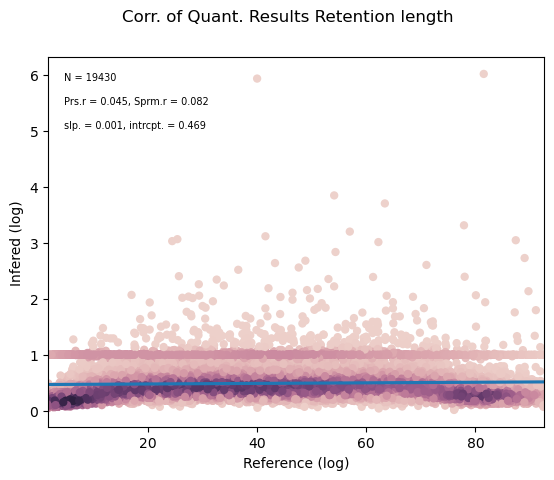

(array([0.50913458, 0.47350376, 0.47111839, ..., 0.49820993, 0.49116921,
        0.49120133]),
 array([0.20372458, 0.21981376, 0.01813839, ..., 0.11592993, 0.24551079,
        0.04449867]),
 (array([    0,     1,     2, ..., 19427, 19428, 19429]),))

In [56]:
import result_analysis.result_analysis
reload(result_analysis.result_analysis)
from result_analysis.result_analysis import PlotCorr
PlotCorr(Maxquant_result['Retention time'], 
         Maxquant_result['Retention length'], 
         filter_thres = 0,
         show_diag=False,
         log=False)

## Elution inference

# In silico digestion

## isotope envelope calculation

In [9]:
digest_path = '/mnt/cmnfs/proj/ORIGINS/data/protMSD/GCF_profile/in_silico_digest.tsv'
digest_out_path = '/mnt/cmnfs/proj/ORIGINS/data/protMSD/GCF_profile/obs_digest_unique_seq.tsv'
msconvert_file = '/mnt/cmnfs/proj/ORIGINS/data/protMSD/GCF_profile/msconvert_profile.mzML' # path to the data input in mzML format, containing only MS1 level data
digest = pd.read_csv(digest_path,sep='\t')

<Axes: >

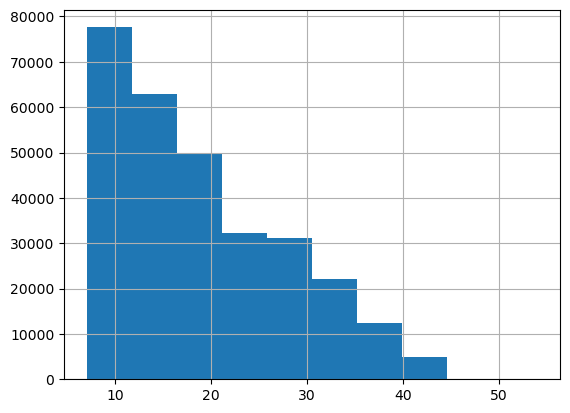

In [10]:
digest_unique_seq = digest.groupby(['Sequence']).first().reset_index()
obs_digest_unique_seq = digest_unique_seq[(digest_unique_seq['Peptide_mass']>300) & (digest_unique_seq['Peptide_mass']<4600) & (digest_unique_seq['Peptide_size'] >= 7)]
obs_digest_unique_seq.Peptide_size.hist()

<Axes: >

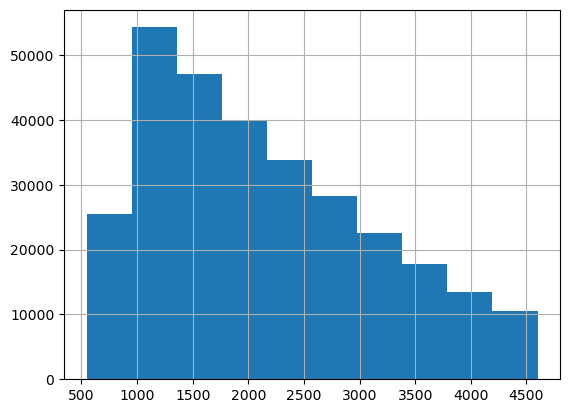

In [11]:
obs_digest_unique_seq.Peptide_mass.hist()

In [12]:
obs_digest_unique_seq.loc[:, 'Peptide_mass_round2'] = np.round(obs_digest_unique_seq['Peptide_mass'], 2)
obs_digest_unique_seq.loc[:, 'Peptide_mass_round3'] = np.round(obs_digest_unique_seq['Peptide_mass'], 3)

In [13]:
obs_digest_unique_seq.columns

Index(['Sequence', 'Original_header', 'No_peptide', 'Enzyme', 'Cleaving_pos',
       'Peptide_size', 'Peptide_mass', 'pI', 'Peptide_mass_round2',
       'Peptide_mass_round3'],
      dtype='object')

In [14]:
unique_mono2_seq = obs_digest_unique_seq.groupby('Peptide_mass_round2').agg({'Sequence':'count'}).reset_index()
unique_mono3_seq = obs_digest_unique_seq.groupby('Peptide_mass_round3').agg({'Sequence':'count'}).reset_index()

In [15]:
unique_mono2_seq.loc[unique_mono2_seq['Sequence'] >1, 'Sequence'].describe()
unique_mono3_seq.loc[unique_mono3_seq['Sequence'] >1, 'Sequence'].describe()

count    59573.000000
mean         4.204539
std          3.070116
min          2.000000
25%          2.000000
50%          3.000000
75%          5.000000
max         42.000000
Name: Sequence, dtype: float64

count    47788.000000
mean         2.994810
std          2.160483
min          2.000000
25%          2.000000
50%          2.000000
75%          3.000000
max         39.000000
Name: Sequence, dtype: float64